In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
class Individual:
    def __init__(self, functions, lb, ub):
        self.functions = functions
        self.lb = lb
        self.ub = ub
        self.code = np.random.random(len(lb)) * (ub - lb) + lb
        self.fvalue = np.empty(len(functions))
        self.evaluate()

    def evaluate(self):
        for i in range(len(self.functions)):
            self.fvalue[i] = self.functions[i](self.code)

In [3]:
# Tournament selection, picking a random member of the tournaments Pareto front

def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)
    varNum = len(chosen)
    fNum = len(chosen[0].functions)

    pareto_front_ids = []
    for i in range(varNum):
        is_pareto_optimal = True

        for j in range(varNum):
            if i != j:
                is_dominated = True
                for k in range(fNum):
                    is_dominated &= chosen[i].fvalue[k] > chosen[j].fvalue[k]
                if is_dominated:
                    is_pareto_optimal = False
                    break
        if is_pareto_optimal:
            pareto_front_ids.append(i)

    return chosen[random.choice(pareto_front_ids)]

In [4]:
# Whole arithmetic recombination

def crossover(parent1, parent2, child1, child2, alpha = 0.5):
    for i in range(len(child1.code)):
        child1.code[i] = parent1.code[i] * alpha + parent2.code[i] * (1 - alpha)
        child2.code[i] = parent2.code[i] * alpha + parent1.code[i] * (1 - alpha)

In [5]:
# Uniform mutation

def mutation(individual, mutation_prob):
    for i in range(len(individual.code)):
        if np.random.random() < mutation_prob:
            individual.code[i] = np.random.random() * (individual.ub[i] - individual.lb[i]) + individual.lb[i]

In [6]:
def ga(functions, lb, ub, pop_size, num_generations, tournament_size, elitism_size, crossover_alpha, mutation_prob):
    # Initializing population
    population = [Individual(functions, lb, ub) for _ in range(pop_size)]
    new_population = population.copy()

    fNum = len(population[0].functions)

    for i in range(num_generations):
        # Elitism
        pareto_front_ids = []
        for i in range(pop_size):
            is_pareto_optimal = True
    
            for j in range(pop_size):
                if i != j:
                    is_dominated = True
                    for k in range(fNum):
                        is_dominated &= population[i].fvalue[k] > population[j].fvalue[k]
                    if is_dominated:
                        is_pareto_optimal = False
                        break
            if is_pareto_optimal:
                pareto_front_ids.append(i)
                if len(pareto_front_ids) == elitism_size:
                    break
    
        elites = np.array([population[i] for i in pareto_front_ids])
        elite_size = min(len(elites), elitism_size)
        new_population[:elite_size] = elites[:elite_size]
        if elite_size % 2 == 0:
            new_population[elite_size] = population[elite_size]
        for j in range(elite_size, pop_size, 2):
            # Selecting "optimal" parents for crossover
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)

            # Crossing-over the parent code into children
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1], alpha=crossover_alpha)

            # Mutating the children
            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)

            # Calculating the children's function value/fitness
            new_population[j].evaluate()
            new_population[j+1].evaluate()
        
        population = new_population.copy()

    pareto_front_ids = []
    # Finding pareto front of the final population
    for i in range(pop_size):
        is_pareto_optimal = True

        for j in range(pop_size):
            if i != j:
                is_dominated = True
                for k in range(fNum):
                    is_dominated &= population[i].fvalue[k] > population[j].fvalue[k]
                if is_dominated:
                    is_pareto_optimal = False
                    break
        if is_pareto_optimal:
            pareto_front_ids.append(i)

    pareto_front = np.array([population[i] for i in pareto_front_ids])

    # Plotting results
    if fNum == 2:
        plt.xlabel('f1(x)')
        plt.ylabel('f2(x)')
        plt.scatter([x.fvalue[0] for x in population], [y.fvalue[1] for y in population])
        plt.scatter([x.fvalue[0] for x in pareto_front], [y.fvalue[1] for y in pareto_front], label = 'pareto_front')
        plt.legend()
    elif fNum == 3:
        ax = plt.figure().add_subplot(projection='3d')
        ax.set_xlabel('f1(x)')
        ax.set_ylabel('f2(x)')
        ax.set_zlabel('f3(x)')
        ax.scatter([x.fvalue[0] for x in population], [y.fvalue[1] for y in population], [z.fvalue[2] for z in population])
        ax.scatter([x.fvalue[0] for x in pareto_front], [y.fvalue[1] for y in pareto_front], [z.fvalue[2] for z in pareto_front], label = 'pareto_front')
        ax.legend()
    else:
        print("Too many dimensions to plot!")

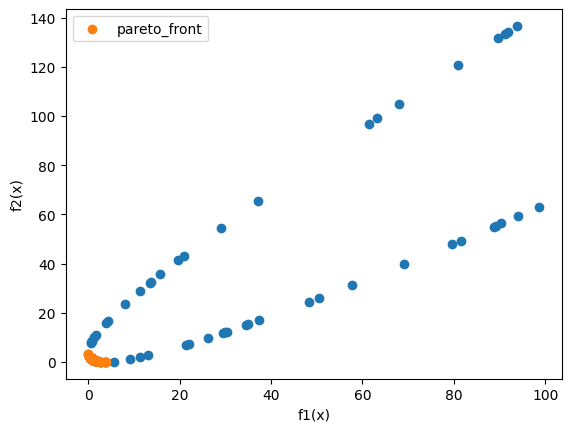

In [7]:
# Schaffer function N.1
# -A <= X <= A, where A is between 10 and 10e5, higher A's increasing the difficulty of the problem

def f1(x):
    return x[0]**2

def f2(x):
    return (x[0]-2)**2

A = 10
lower_bounds = np.array([-A])
upper_bounds = np.array([A])

ga(functions=[f1,f2], lb=lower_bounds, ub=upper_bounds, pop_size=1000, num_generations=100, tournament_size=4, elitism_size=10, crossover_alpha=0.3, mutation_prob=0.05)

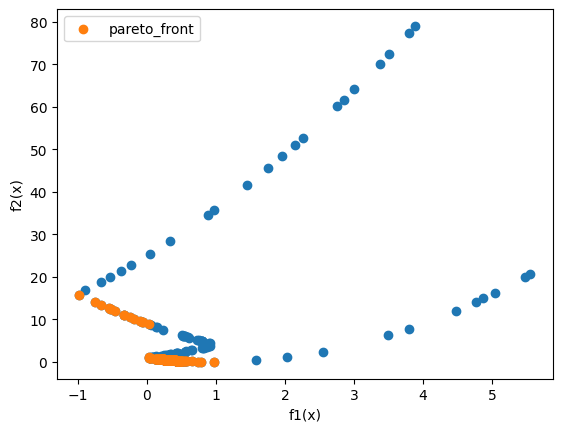

In [8]:
# Schaffer function N.2
# -5 <= x <= 10

def f1(x):
    if x[0] <= 1:
        return -x[0]
    elif x[0] <= 3:
        return x[0] - 2
    elif x[0] <= 4:
        return 4 - x[0]
    else:
        return x[0] - 4
        
def f2(x):
    return (x[0] - 5)**2

lower_bounds = np.array([-5])
upper_bounds = np.array([10])

ga(functions=[f1,f2], lb=lower_bounds, ub=upper_bounds, pop_size=1000, num_generations=100, tournament_size=4, elitism_size=10, crossover_alpha=0.3, mutation_prob=0.05)

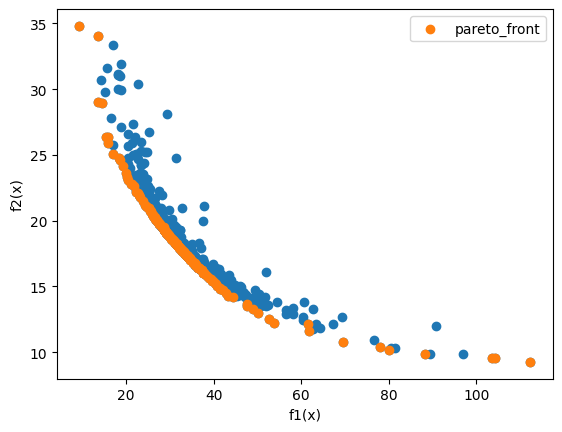

In [9]:
# Bihn and Korn function without constraints
# 0 <= x <= 5
# 0 <= y <= 3

def f1(x):
    return 4*(x[0]**2 + x[1]**2)

def f2(x):
    return (x[0]-5)**2 + (x[1]-5)**2

lower_bounds = np.array([0, 0])
upper_bounds = np.array([5, 3])

ga(functions=[f1,f2], lb=lower_bounds, ub=upper_bounds, pop_size=1000, num_generations=100, tournament_size=4, elitism_size=10, crossover_alpha=0.3, mutation_prob=0.05)

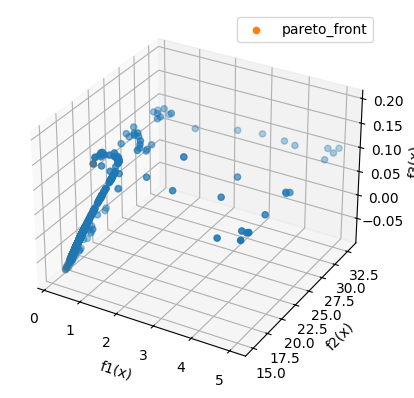

In [10]:
# Viennet function
# -3 <= x,y <= 3

def f1(x):
    return 0.5*(x[0]**2 + x[1]**2) + np.sin(x[0]**2 + x[1]**2)

def f2(x):
    return ((3*x[0] - 2*x[1] + 4)**2)/8 + ((x[0] - x[1] + 1)**2)/27 + 15

def f3(x):
    return 1/(x[0]**2 + x[1]**2 + 1) - 1.1*np.exp(-(x[0]**2+x[1]**2))

lower_bounds = np.array([-3, -3])
upper_bounds = np.array([3, 3])

ga(functions=[f1,f2,f3], lb=lower_bounds, ub=upper_bounds, pop_size=1000, num_generations=100, tournament_size=4, elitism_size=10, crossover_alpha=0.3, mutation_prob=0.05)